In [12]:
import pandas as pd
import os
import json
from ete3 import Tree
from Bio import Phylo

In [56]:
def annotate_tree_with_indices(newick_str, outgroup_name, file_path=None):
    """
    Traverses the Newick tree using ete3, annotates each node with an index.
    Terminal nodes: 0 - outgroup, 1, 2, ... for the rest.
    Internal nodes: Node(idx).
    Returns:
      - tree (with .index and .custom_name on each node)
      - terminal_mapping: {species_name <-> idx} (bidirectional for terminals only)
    If file_path is provided, saves the annotated tree (as newick) and the mapping (as json)
    with suffixes '_annotated.nwk' and '_mapping.json'.
    """
    # Step 1: Load tree
    tree = Tree(newick_str, format=1)

    # Step 2: Clean names (strip suffix after "|")
    for leaf in tree.iter_leaves():
        if '|' in leaf.name:
            leaf.name = leaf.name.split('|', 1)[0]

    # Step 3: Sort terminals (outgroup first)
    terminals = tree.get_leaves()
    sorted_terminals = [t for t in terminals if t.name == outgroup_name] + \
                       sorted([t for t in terminals if t.name != outgroup_name], key=lambda x: x.name)

    # Step 4: Assign terminal indices and build mapping
    terminal_mapping = {}
    for idx, node in enumerate(sorted_terminals):
        node.add_feature("index", idx)
        node.add_feature("custom_name", node.name)
        species_name = node.name
        terminal_mapping[idx] = species_name
        terminal_mapping[species_name] = idx

    # Step 5: Assign internal node indices
    next_internal_idx = len(sorted_terminals)
    for node in tree.traverse("postorder"):
        if not node.is_leaf():
            node.add_feature("index", next_internal_idx)
            node.add_feature("custom_name", f"Node({next_internal_idx})")
            next_internal_idx += 1

    # Step 6: Output to files (if needed)
    if file_path is not None:
        # Temporarily rename nodes to custom_name for writing
        original_names = {}
        for node in tree.traverse():
            original_names[node] = node.name
            node.name = getattr(node, "custom_name", node.name)

        annotated_tree_path = f"{os.path.splitext(file_path)[0]}_annotated.nwk"
        tree.write(format=1, outfile=annotated_tree_path)

        # Restore original names
        for node in tree.traverse():
            node.name = original_names[node]

        # Save mapping as JSON
        mapping_path = f"{os.path.splitext(file_path)[0]}_mapping.json"
        with open(mapping_path, "w") as f:
            json.dump(terminal_mapping, f, indent=2)

        print(f"📝 Annotated tree saved to {annotated_tree_path}")
        print(f"📝 Terminal mapping saved to {mapping_path}")

    return tree, terminal_mapping

In [57]:
newick_tree = "(Leptophobia_aripa|GCA_951799465.1, (Pieris_brassicae|GCF_905147105.1, (Pieris_napi|GCF_905475465.1, (Pieris_rapae|GCF_905147795.1, Pieris_mannii|GCA_028984075.1))));"

In [58]:
tree, mapping = annotate_tree_with_indices(newick_tree, "Leptophobia_aripa")

In [61]:
df = pd.read_csv(r'../Output/test_run_mutiple_species/Leptophobia_aripa__Pieris_brassicae__Pieris_mannii__Pieris_napi__Pieris_rapae.csv.gz')

In [64]:
df.columns = df.columns.str.replace('reference_base', 'taxa0')

In [100]:
ambiguous_counter = 0

def recursive_state_check(node, row, mapping): 
    if node.is_leaf():
        node.add_feature("state", {row[f"taxa{mapping[node.name]}"]})
        return node.state

    # Recursively compute children's states
    left_state = recursive_state_check(node.children[0], row, mapping)
    right_state = recursive_state_check(node.children[1], row, mapping)

    intersect = left_state & right_state
    node_state = intersect if intersect else left_state | right_state
    node.add_feature("state", node_state)
    return node_state


def recursive_fitch(node, parent_state, row, mutation_dict, verbose=False):
    global ambiguous_counter
    next_state = parent_state

    # Only if the parent state isn't compatible with the current state
    if parent_state not in node.state:
        if len(node.state) > 1:
            ambiguous_counter += 1
            if verbose:
                print(f"{node.name} state is ambiguous: {node.state}. Cannot resolve mutations in this subtree.")
            return
        else:
            next_state = list(node.state)[0]
            parent_name = node.up.custom_name if node.up else "ROOT"
            child_name = node.custom_name
            branch_key = f"{parent_name}→{child_name}"
            
            # Build mutation string
            mutation = f"{row['left']}[{parent_state}>{next_state}]{row['right']}"
            pos = row['position']
            mutation_dict.setdefault(branch_key, []).append((pos, mutation))

    # Recurse on children if not a leaf
    if not node.is_leaf():
        recursive_fitch(node.children[0], next_state, row, mutation_dict, verbose)
        recursive_fitch(node.children[1], next_state, row, mutation_dict, verbose)


def fitch(tree_root, row, mapping, mutation_dict, verbose=False):
    global ambiguous_counter
    root_state = recursive_state_check(tree_root, row, mapping)
    if len(root_state) == 1:
        root_base = list(root_state)[0]
        recursive_fitch(tree_root, root_base, row, mutation_dict, verbose)
    else:
        ambiguous_counter += 1
        if verbose:
            print(f"Root state is ambiguous: {root_state}. Cannot resolve mutations.")

    return mutation_dict


In [101]:
mutation_dict = {}
for i in range(len(df)):
    mutation_dict = fitch(tree, df.iloc[i], mapping, mutation_dict, verbose=False)

In [ ]:
import pandas as pd
df = pd.read_csv(r'../Output/test_run_mutiple_species/mutation_spectras.tsv', index_col = 0, sep = '\t')

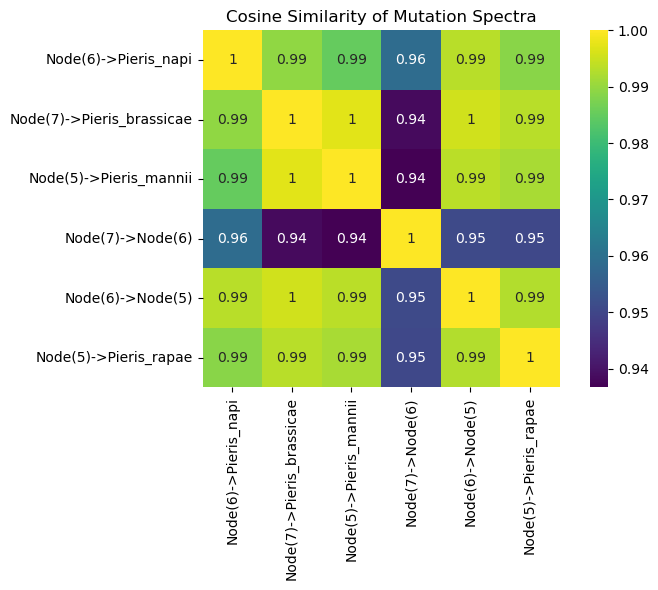

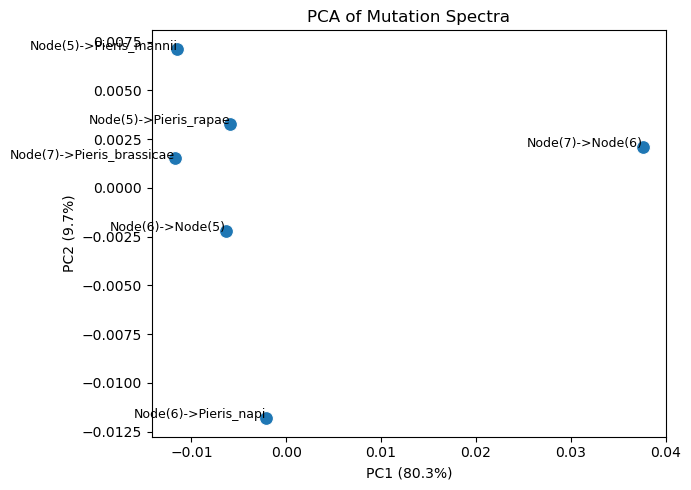

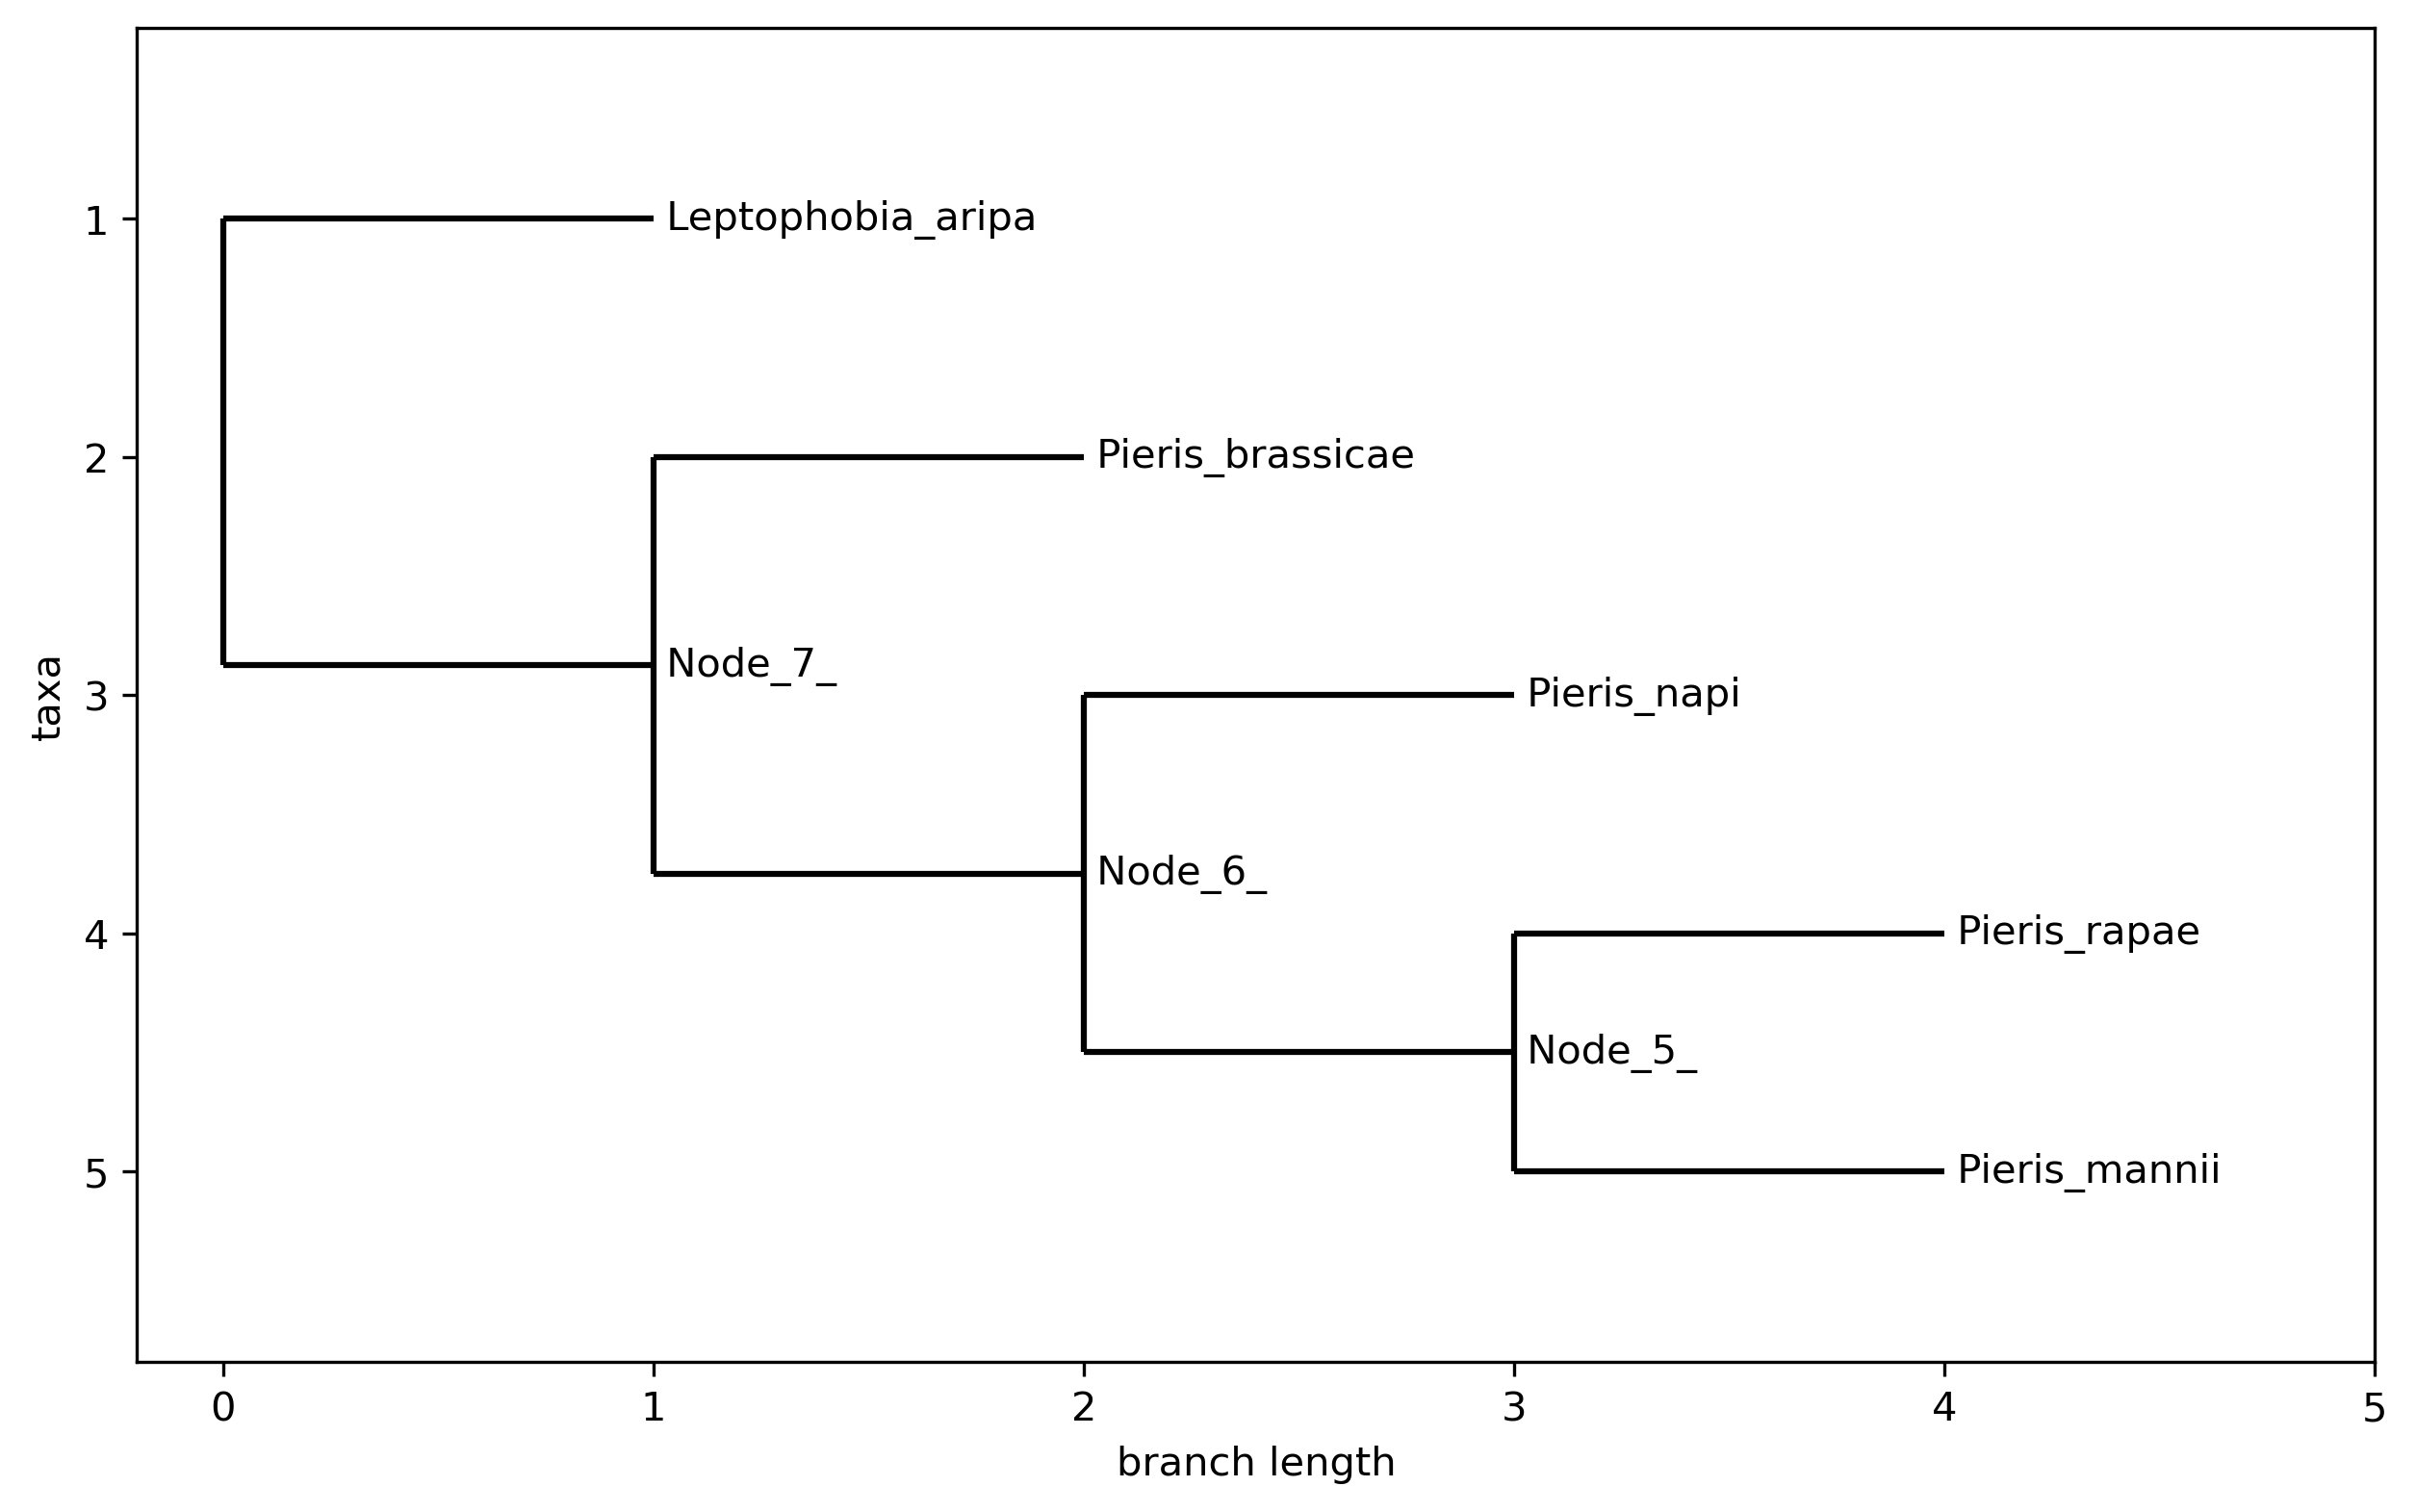

Node(6)->Pieris_napi         145279
Node(7)->Pieris_brassicae    224756
Node(5)->Pieris_mannii       103260
Node(7)->Node(6)              45089
Node(6)->Node(5)             124271
Node(5)->Pieris_rapae         99971
dtype: int64


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def plot_mutation_spectrum_comparison(spectra_df, output_prefix=None):
    """
    spectra_df: DataFrame with shape (n_mutations, n_species)
                rows = mutation types (e.g. A[C>T]G)
                columns = species names
    """
    # Ensure mutation types are index and transpose to shape (n_species, n_mutations)
    spectra_df = spectra_df.fillna(0)
    spectra_df = spectra_df.loc[sorted(spectra_df.index)]  # optional: sort mutations
    norm_df = spectra_df.div(spectra_df.sum(axis=0), axis=1).T  # shape (species x mutations)

    # === Cosine similarity heatmap ===
    cosine_sim = cosine_similarity(norm_df)
    cosine_df = pd.DataFrame(cosine_sim, index=norm_df.index, columns=norm_df.index)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cosine_df, annot=True, cmap="viridis", square=True)
    plt.title("Cosine Similarity of Mutation Spectra")
    plt.tight_layout()
    if not output_prefix:
        plt.show()
    # plt.savefig(f"{output_prefix}_cosine_heatmap.png", dpi=300)
    plt.close()

    # === PCA plot ===
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(norm_df)

    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=norm_df.index)

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

    for label, (x, y) in pca_df.iterrows():
        plt.text(x, y, label, fontsize=9, ha='right')

    plt.title("PCA of Mutation Spectra")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.tight_layout()
    # plt.savefig(f"{output_prefix}_pca.png", dpi=300)
    if not output_prefix:
        plt.show()
    plt.close()

plot_mutation_spectrum_comparison(df)

tree = Phylo.read(r'../Output/test_run_mutiple_species/annotated_tree.nwk', "newick")

# Create the plot
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, do_show=False, axes=ax)

# Save the figure
plt.show()
print(df.sum())


In [15]:
import os
import shutil
import subprocess
import pandas as pd
from ete3 import Tree

def write_phylip_infile(df, outfile):
    """
    Write a mutation matrix DataFrame to PHYLIP sequential format.
    Rows = taxa, Columns = sites
    """
    with open(outfile, 'w') as f:
        f.write(f"{df.shape[0]} {df.shape[1]}\n")
        for taxon, row in df.iterrows():
            name = taxon[:10].ljust(10)  # PHYLIP requires 10-char names
            sequence = ''.join(row.values)
            f.write(f"{name}{sequence}\n")

def write_intree(tree, outfile):
    """
    Save ETE3 tree to Newick file with internal node names.
    """
    original_names = {}
    for node in tree.traverse():
        original_names[node] = node.name
        node.name = getattr(node, "custom_name", node.name)

    tree.write(outfile=outfile, format=1)

    for node in tree.traverse():
        node.name = original_names[node]

def run_phylip_dnapars(df, output_dir, exe_path, tree=None, prefix="run1"):
    """
    Run PHYLIP dnapars on a mutation matrix DataFrame.

    Args:
        df (pd.DataFrame): rows = taxa (index), columns = positions (A/C/G/T/-)
        output_dir (str): where to run PHYLIP and store outputs
        exe_path (str): path to dnapars executable
        tree (Tree, optional): ETE3 Tree. If provided, will save as intree
        prefix (str): prefix for outfile/outtree naming

    Returns:
        dict: paths to {outfile, outtree}
    """
    os.makedirs(output_dir, exist_ok=True)
    os.chdir(output_dir)

    # Clean any old PHYLIP files
    for fname in ["infile", "intree", "outfile", "outtree"]:
        if os.path.exists(fname):
            os.remove(fname)

    # Write input file
    write_phylip_infile(df, "infile")

    # If tree is provided, write intree
    if tree:
        write_intree(tree, "intree")

    # Run PHYLIP
    input_text = "Y\n"
    result = subprocess.run([exe_path], input=input_text, text=True, capture_output=True)

    if result.returncode != 0:
        raise RuntimeError(f"PHYLIP error:\n{result.stderr}")

    # Rename outputs
    out_paths = {}
    if os.path.exists("outfile"):
        new_out = f"{prefix}.outfile"
        shutil.move("outfile", new_out)
        out_paths['outfile'] = os.path.abspath(new_out)
    if os.path.exists("outtree"):
        new_tree = f"{prefix}.outtree"
        shutil.move("outtree", new_tree)
        out_paths['outtree'] = os.path.abspath(new_tree)

    return out_paths


In [23]:
import pandas as pd

# Load your mutation matrix
df = pd.read_csv(r"\\wsl.localhost\Ubuntu\home\asafpinhasi\Projects\species_mutation_extraction\Output\test_run_mutiple_species\mutations.csv.gz", index_col=0)


# Convert it to the PHYLIP-required format: rows = species, columns = sites
# If your CSV is already structured that way, this step may not be needed
df = df.astype(str)  # ensure all entries are single characters like A/C/G/T
df = df.iloc[:1000,:]

infile_path = "infile"  # PHYLIP input file
taxa_cols = df.columns[df.columns.str.startswith('taxa')]
# Write PHYLIP input file
with open(infile_path, 'w') as f:
    f.write(f"{len(taxa_cols)} {len(df)}\n")
    for col in taxa_cols:
        sequence = ''.join(df[col].astype(str).values).replace(' ', '-').upper()
        f.write(f"{col.ljust(10)}{sequence}\n")

In [22]:
print(os.path.abspath(infile_path))

\\wsl.localhost\Ubuntu\home\asafpinhasi\Projects\species_mutation_extraction\Output\test_run_mutiple_species\phylip_run\infile
